<a href="https://colab.research.google.com/github/AyorindeTayo/ANN-prediction-of-Hardness-using-Tensor-Flow/blob/master/ANNhardness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(tf.__version__)

2.3.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6ytpaazm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6ytpaazm
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dcf6d428a23727780cedcb671ebd9791b1b6f106_-cp36-none-any.whl size=133393 sha256=d708361bea1f1bf8d7c91b461a1be02e2b8ddeb4c591c82f788859e7017a9a44
  Stored in directory: /tmp/pip-ephem-wheel-cache-qtb2cai1/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


# A quick exploratory data analysis

In [3]:
from google.colab import files
files.upload()

Saving data_1004.xlsx to data_1004.xlsx


{'data_1004.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\xa7\x0c\xebyh\x01\x00\x00\r\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [4]:
df=pd.read_excel('data_1004.xlsx')
df.head()

,S-temp,S-time,Wel-power,Wel-speed,Hardness
0,1000,5,1500,3,343.7
1,1000,5,1500,3,350.1
2,1000,5,1500,3,351.7
3,1000,5,1500,3,365.6
4,1000,5,1500,3,337.5


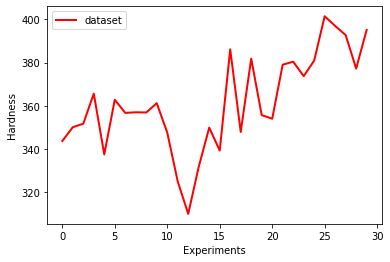

In [5]:
plt.plot(df.index, df['Hardness'], color='r', lw=2, label='dataset')
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.legend()
plt.show()

# Preparation of the data for training

In [12]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("Hardness")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
S-temp,24.0,1000.000000,83.405766,900.0,900.0,1000.0,1100.0,1100.0
S-time,24.0,6.666667,2.407717,5.0,5.0,5.0,10.0,10.0
Wel-power,24.0,1733.333333,209.899907,1500.0,1500.0,1700.0,2000.0,2000.0
Wel-speed,24.0,2.666667,0.481543,2.0,2.0,3.0,3.0,3.0


In [14]:
train_labels = train_dataset.pop('Hardness')
test_labels = test_dataset.pop('Hardness')

# Defining the function to normalize the data

In [16]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


# Defining the shallow neural network model

In [17]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [18]:
model = build_model()

# Training and validation of the model

In [19]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [20]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:132699.7031,  mae:363.7069,  mse:132699.7031,  val_loss:128589.5000,  val_mae:358.3178,  val_mse:128589.5000,  
....................................................................................................
Epoch: 100, loss:113386.8516,  mae:336.3690,  mse:113386.8516,  val_loss:116505.4531,  val_mae:341.1052,  val_mse:116505.4531,  
....................................................................................................
Epoch: 200, loss:66427.0312,  mae:255.2946,  mse:66427.0312,  val_loss:84841.2266,  val_mae:290.9863,  val_mse:84841.2266,  
....................................................................................................
Epoch: 300, loss:18545.0137,  mae:112.1428,  mse:18545.0137,  val_loss:36164.0859,  val_mae:187.8808,  val_mse:36164.0859,  
....................................................................................................
Epoch: 400, loss:1494.5309,  mae:28.5267,  mse:1494.5309,  val_loss:2654.9646,  val_mae:4

# Learning and validation results

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,198.030991,9.703967,198.030991,327.928345,13.949926,327.928345,995
996,198.046341,9.593201,198.046341,298.084747,12.636969,298.084747,996
997,198.031082,9.703968,198.031082,327.928894,13.949939,327.928894,997
998,198.046417,9.593207,198.046417,298.084930,12.636963,298.084930,998
999,198.031082,9.703967,198.031082,327.930481,13.949976,327.930481,999


# Plotting the results

In [22]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=3)

Text(0, 0.5, 'MAE [Hardness]')

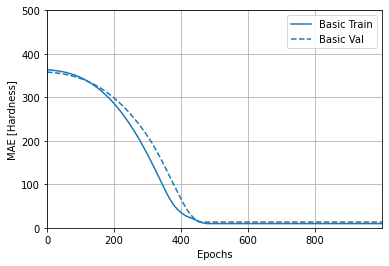

In [ ]:
plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 500])
plt.ylabel('MAE [Hardness]')   #mean_absolute_error

#plt.savefig('1.pdf')

#files.download('1.pdf')

Text(0, 0.5, 'MSE [Hardness]')

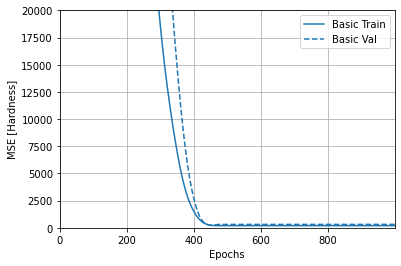

In [23]:
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 20000])
plt.ylabel('MSE [Hardness]') #mean_squared_error

#plt.savefig('2.pdf')

#files.download('2.pdf')

In [24]:
loss, mae, mse = model.evaluate(normed_train_data, train_labels, verbose=2)

print("Training Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 225.1056 - mae: 10.5009 - mse: 225.1056
Training Mean Abs Error: 10.50 Hardness


In [26]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 353.9202 - mae: 14.7954 - mse: 353.9202
Testing set Mean Abs Error: 14.80 Hardness


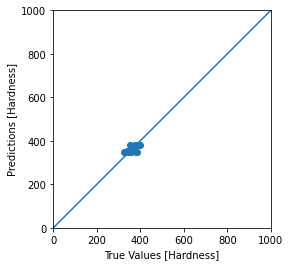

In [28]:
train_predictions = model.predict(normed_train_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#plt.savefig('3.pdf')

#files.download('3.pdf')

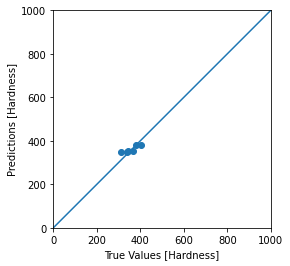

In [30]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

#plt.savefig('4.pdf')

#files.download('4.pdf')

In [31]:
t1=np.corrcoef(test_labels, test_predictions)[0,1]
k1=np.corrcoef(train_labels, train_predictions)[0,1]
print('the corralation on the training set is',t1,'and that on the test set is',k1)

the corralation on the training set is 0.8802882115063212 and that on the test set is 0.655061532664224


In [32]:
train_pred = model.predict(normed_train_data).flatten()
test_pred = model.predict(normed_test_data).flatten()

err1 = 100*(np.abs(test_pred - test_labels))/test_labels
err2=100*(np.abs(train_pred - train_labels))/train_labels

In [33]:
print(test_labels)
print('-'*50)
print(test_pred)
print('-'*50)
print(err1)

0     343.7
3     365.6
12    310.0
15    339.3
21    379.0
25    401.4
Name: Hardness, dtype: float64
--------------------------------------------------
[354.67755 354.67755 346.8863  346.8863  379.8394  379.8394 ]
--------------------------------------------------
0      3.193934
3      2.987541
12    11.898804
15     2.235865
21     0.221474
25     5.371354
Name: Hardness, dtype: float64


In [35]:
print(train_labels)
print('-'*50)
print(train_pred)
print('-'*50)
print(err2)

2     351.7
28    377.2
13    331.8
10    347.6
26    396.9
24    380.9
27    392.7
11    325.0
17    347.9
22    380.4
5     362.8
16    386.1
8     356.9
14    349.9
23    373.7
20    354.0
1     350.1
29    395.1
6     356.7
4     337.5
18    381.8
19    355.7
9     361.2
7     357.0
Name: Hardness, dtype: float64
--------------------------------------------------
[354.67755 379.8394  346.8863  346.8863  379.8394  379.8394  379.8394
 346.8863  346.8863  379.8394  354.67755 346.8863  354.67755 346.8863
 379.8394  379.8394  354.67755 379.8394  354.67755 354.67755 346.8863
 346.8863  354.67755 354.67755]
--------------------------------------------------
2      0.846617
28     0.699731
13     4.546803
10     0.205325
26     4.298467
24     0.278449
27     3.274921
11     6.734244
17     0.291379
22     0.147375
5      2.238823
16    10.156361
8      0.622709
14     0.861306
23     1.642865
20     7.299262
1      1.307498
29     3.862469
6      0.566989
4      5.089645
18     9.144502
1

# Model with early stopping

In [36]:
model1 = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model1.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])



Epoch: 0, loss:133247.7969,  mae:364.4475,  mse:133247.7969,  val_loss:128879.5000,  val_mae:358.7175,  val_mse:128879.5000,  
....................................................................................................
Epoch: 100, loss:121478.2891,  mae:348.1350,  mse:121478.2891,  val_loss:121317.3281,  val_mae:348.0355,  val_mse:121317.3281,  
....................................................................................................
Epoch: 200, loss:85980.9453,  mae:292.4651,  mse:85980.9453,  val_loss:97846.1484,  val_mae:312.5908,  val_mse:97846.1484,  
....................................................................................................
Epoch: 300, loss:36270.9805,  mae:180.9429,  mse:36270.9805,  val_loss:57924.8203,  val_mae:239.9279,  val_mse:57924.8203,  
....................................................................................................
Epoch: 400, loss:6319.4517,  mae:58.0332,  mse:6319.4517,  val_loss:13298.4844,  val_mae:

# Results of the model with early stopping

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

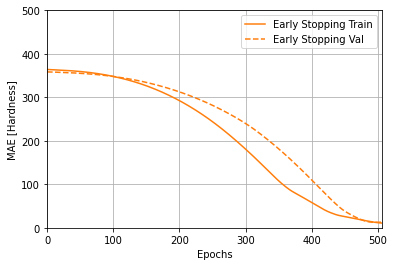

In [37]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 500])
plt.ylabel('MAE [Hardness]') #mean_absolute_error

plt.savefig('5.pdf')

files.download('5.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

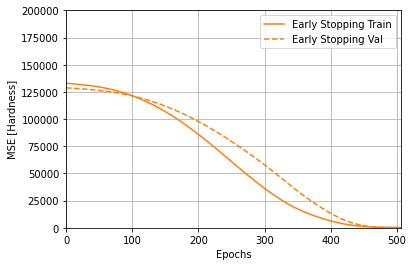

In [38]:
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylim([0, 200000])
plt.ylabel('MSE [Hardness]') #mean_squared_error

plt.savefig('6.pdf')

files.download('6.pdf')

# Training loss

In [39]:
loss, mae, mse = model1.evaluate(normed_train_data, train_labels, verbose=2)

print("Training set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 215.8843 - mae: 10.9430 - mse: 215.8843
Training set Mean Abs Error: 10.94 Hardness


# Test loss

In [40]:
loss, mae, mse = model1.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Hardness".format(mae))


1/1 - 0s - loss: 415.2683 - mae: 16.3137 - mse: 415.2683
Testing set Mean Abs Error: 16.31 Hardness


# Training plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

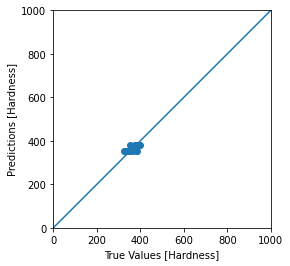

In [41]:
train_predictions = model1.predict(normed_train_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.savefig('7.pdf')

files.download('7.pdf')

# Test plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

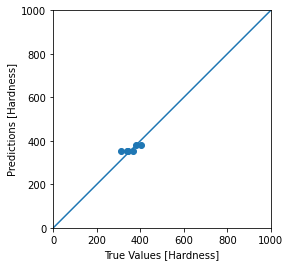

In [42]:
test_predictions = model1.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Hardness]')
plt.ylabel('Predictions [Hardness]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.savefig('8.pdf')

files.download('8.pdf')

In [ ]:
test_predictions 

array([351.38266, 351.38266, 351.1766 , 351.1766 , 382.99057, 382.99057],
      dtype=float32)

# Corralation coefficient

In [43]:
t=np.corrcoef(test_labels, test_predictions)[0,1]
k=np.corrcoef(train_labels, train_predictions)[0,1]
print('the corralation on the training set is',t,'and that on the test set is',k)

the corralation on the training set is 0.8033167776947405 and that on the test set is 0.6673360383868513


# Percentage Errors on the predictions

The percentage error is defined as follows:

$$PE= 100\times \Big| \dfrac{TV-PV}{TV}\Big |$$

Where $TV$, $PV$ are the true values and the predicted value respectively.

In [44]:
error1 = 100*(np.abs(test_predictions - test_labels))/test_labels
error2=100*(np.abs(train_predictions - train_labels))/train_labels

In [45]:
print(test_labels)
print('-'*50)
print(test_predictions)
print('-'*50)
print(error1)

0     343.7
3     365.6
12    310.0
15    339.3
21    379.0
25    401.4
Name: Hardness, dtype: float64
--------------------------------------------------
[351.09045 351.09045 351.441   351.441   382.75613 382.75613]
--------------------------------------------------
0      2.150263
3      3.968694
12    13.368068
15     3.578252
21     0.991064
25     4.644710
Name: Hardness, dtype: float64


In [ ]:
print(train_labels)
print('-'*50)
print(train_predictions)
print('-'*50)
print(error2)

2     351.7
28    377.2
13    331.8
10    347.6
26    396.9
24    380.9
27    392.7
11    325.0
17    347.9
22    380.4
5     362.8
16    386.1
8     356.9
14    349.9
23    373.7
20    354.0
1     350.1
29    395.1
6     356.7
4     337.5
18    381.8
19    355.7
9     361.2
7     357.0
Name: Hardness, dtype: float64
--------------------------------------------------
[353.13495 382.73422 349.3789  349.3789  382.73422 382.73422 382.73422
 349.3789  349.3789  382.73422 353.13495 349.3789  353.13495 349.3789
 382.73422 382.73422 353.13495 382.73422 353.13495 353.13495 349.3789
 349.3789  353.13495 353.13495]
--------------------------------------------------
2     0.408004
28    1.467185
13    5.298043
10    0.511768
26    3.569105
24    0.481550
27    2.537758
11    7.501202
17    0.425095
22    0.613623
5     2.664016
16    9.510773
8     1.054932
14    0.148926
23    2.417507
20    8.117012
1     0.866881
29    3.129784
6     0.999454
4     4.632577
18    8.491643
19    1.777086
9     

In [ ]:
test_predictions

array([353.13495, 353.13495, 349.3789 , 349.3789 , 382.73422, 382.73422],
      dtype=float32)

# Trying something

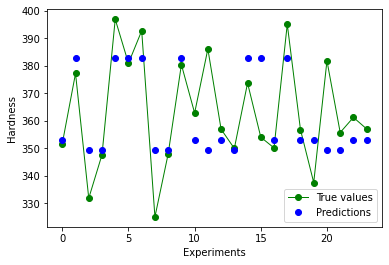

In [ ]:
k=pd.Series(train_labels).reset_index(drop=True)
m=pd.Series(train_predictions).reset_index(drop=True)

plt.plot(k.index, k, color='green',marker='o', label='True values', lw=1)
plt.plot(m.index,m, 'bo', label='Predictions')
plt.legend()
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.show()

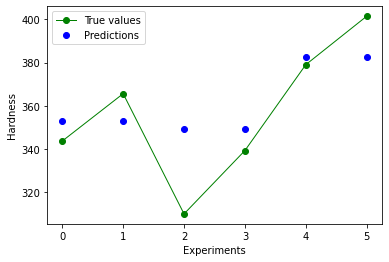

In [ ]:
l=pd.Series(test_labels).reset_index(drop=True)
n=pd.Series(test_predictions).reset_index(drop=True)

plt.plot(l.index, l, color='green',marker='o', label='True values', lw=1)
plt.plot(n.index,n, 'bo', label='Predictions')
plt.legend()
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.show()

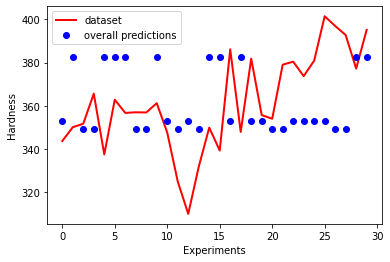

In [ ]:
d_f=pd.concat([pd.Series(train_predictions),pd.Series(test_predictions)])

plt.plot(df.index, df['Hardness'], color='r', label='dataset', lw=2)
plt.plot(df.index, d_f, 'bo', label='overall predictions')
plt.xlabel('Experiments')
plt.ylabel('Hardness')
plt.legend()
plt.show()


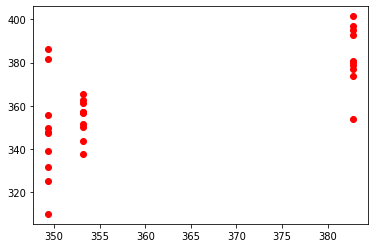

In [ ]:
dff=pd.concat([pd.Series(train_labels),pd.Series(test_labels)])
plt.scatter(d_f, dff, color='r', label='dataset')


#plt.savefig('test.pdf')

#files.download('test.pdf')

In [ ]:



def build_modell():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), 
    activity_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model




model2 = build_modell()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model1.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:199.3996,  mae:9.8890,  mse:199.3996,  val_loss:288.4353,  val_mae:13.3604,  val_mse:288.4353,  
....................................................................................................
Epoch: 100, loss:198.0559,  mae:9.6988,  mse:198.0559,  val_loss:328.1279,  val_mae:13.9786,  val_mse:328.1279,  
....................................................................................................
Epoch: 200, loss:198.0584,  mae:9.6990,  mse:198.0584,  val_loss:328.1436,  val_mae:13.9792,  val_mse:328.1436,  
....................................................................................................
Epoch: 300, loss:198.0583,  mae:9.6990,  mse:198.0583,  val_loss:328.1470,  val_mae:13.9794,  val_mse:328.1470,  
....................................................................................................
Epoch: 400, loss:198.0587,  mae:9.6990,  mse:198.0587,  val_loss:328.1458,  val_mae:13.9793,  val_mse:328.1458,  
...........................

In [ ]:
loss, mae, mse = model2.evaluate(normed_train_data, train_labels, verbose=2)

print("Training set Mean Abs Error: {:5.2f} Hardness".format(mae))

1/1 - 0s - loss: 131830.1875 - mae: 362.5625 - mse: 131829.5469
Training set Mean Abs Error: 362.56 Hardness


dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


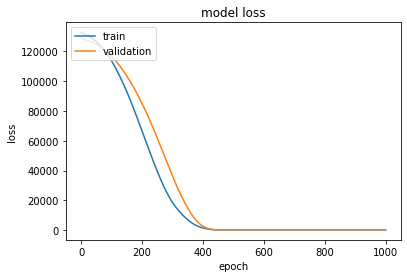

In [46]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()